In [1]:
import pandas as pd
import numpy as np
import json
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from pathlib import Path

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract
from utils.constants import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Check if we are running on Windows or Linux using os
from archetypal import settings
if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Iteration settings

In [4]:
# Get grasshopper json data for config
data_dir = "D:/DATA/AutozonerTests"
name = "test"

settings_dir = Path(data_dir) / f"{name}_settings.json"
results_dir = Path(data_dir) / f"{name}_CSresults.json"
# settings_dict_dir = "D:/DATA/SingleShoeboxTests/Shoebox_sched3.json"
with open(settings_dir, 'r') as f:
    settings_dict = json.load(f)

In [5]:
# epw = EPW("/teamspace/uploads/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
# epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
# epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
epw_path = "C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw"
# epw = EPW("/teamspace/uploads/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
# epw = EPW("/teamspace/uploads/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
epw = EPW(epw_path)
climate = extract(epw)

In [6]:
blds_settings = settings_dict["BuildingSettings"]
config = settings_dict["ShoeboxConfig"].copy()

In [7]:
"""
Make Schedules
"""
all_schedules = pd.read_hdf("data/schedules.h5")
idx = blds_settings["schedule_index"]
print(idx)
schedules = np.reshape(all_schedules.loc[all_schedules.index[idx*3][0]].to_numpy(), (1,3,8760))
schedules.shape

5


(1, 3, 8760)

In [8]:
def get_tmas_idx(val):
    if val >= ThermalMassCapacities.Concrete:
        hot_bin = ThermalMassConstructions.Concrete.value
    elif (
        val < ThermalMassCapacities.Concrete and val >= ThermalMassCapacities.Brick
    ):
        hot_bin = ThermalMassConstructions.Brick.value
    elif (
        val < ThermalMassCapacities.Brick and val >= ThermalMassCapacities.WoodFrame
    ):
        hot_bin = ThermalMassConstructions.WoodFrame.value
    elif val < ThermalMassCapacities.WoodFrame:
        hot_bin = ThermalMassConstructions.SteelFrame.value
    return hot_bin

In [9]:
if settings_dict["Conditioning"]["HeatRecoveryType"] == "None":
    hrv = 0
else:
    hrv = HRV[settings_dict["Conditioning"]["HeatRecoveryType"]].value 
if "occ" in settings_dict["Conditioning"]["MechVentSchedule"].lower():
    vent_mode = 2
else:
    vent_mode = 0

config.update({
    "FacadeMass": get_tmas_idx(float(settings_dict["ShoeboxConfig"]["RoofMass"])), 
    "RoofMass": get_tmas_idx(float(settings_dict["ShoeboxConfig"]["FacadeMass"])),
    "PeopleDensity": float(settings_dict["Loads"]["PeopleDensity"]),
    "EquipmentPowerDensity": float(settings_dict["Loads"]["EquipmentPowerDensity"]),
    "LightingPowerDensity": float(settings_dict["Loads"]["LightingPowerDensity"]),
    "HeatingSetpoint": float(settings_dict["Conditioning"]["HeatingSetpoint"]),
    "CoolingSetpoint": float(settings_dict["Conditioning"]["CoolingSetpoint"]),
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": vent_mode, 
    "VentilationPerArea": float(settings_dict["Conditioning"]["MinFreshAirArea"]/1000),
    "VentilationPerPerson": float(settings_dict["Conditioning"]["MinFreshAirPerson"]/1000),
    "EconomizerSettings": Econ[settings_dict["Conditioning"]["EconomizerType"]].value,
    "RecoverySettings": hrv,
    "Infiltration": float(settings_dict["Infiltration"]["InfiltrationFlowPerExteriorSurfaceArea"]), #/1000
    "wwr": float(settings_dict["ShoeboxConfig"]["wwr"]),
    "building_id": 0,
    "weight": 1,
    "template_idx": 0.0,
})

for i in range(12):
    config[f"shading_{i}"] = 0

In [10]:
blds_settings

{'x_dim': 40.0,
 'y_dim': 40.0,
 'n_floors': 15.0,
 'schedule_index': 5,
 'f2f_height': 4.0}

In [11]:
features = pd.DataFrame(data=config, index=[0])
features = pd.concat([features]*12,axis=0)
features["roof_2_footprint"] = [0,0,1]*4
features["ground_2_footprint"] = [1,0,0]*4
# features["roof_2_footprint"] = [0.25]*12
# features["ground_2_footprint"] = [0.25]*12
features["orientation"] = [*[0]*3,*[np.pi/2]*3,*[np.pi]*3,*[3*np.pi/2]*3]

features.index = range(12)
for i in range(4):
    for j in range(3):
        features.loc[i*3+j,"name"] = f"{['bottom','middle','top'][j]}_{['south','east','north','west'][i]}"
shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=features, schedules=schedules, climate=climate,apply_cops=False, batch_size=32,)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Whitebox Batch Test

In [14]:
from shoeboxer.batch import batch_sim, simulate
# wb_shoebox_results = simulate(
#     features=features.iloc[0],
#     timeseries=schedules.squeeze(),
#     climate=epw_path,
# )

wb_shoebox_results = batch_sim(
    features=features,
    timeseries=schedules.squeeze(),
    climate=epw_path,
    parallel=6,
    psort="name"
)

simulate:   0%|          | 0.00/12.0 [00:00<?, ?runs/s]INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:shoeboxer.geometry_utils:Placing shading around center p

ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.109
ExpandObjects completed in 0.23 seconds


C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 3.00it [00:00, 8.67it/s]
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 0.00it [00:00, ?it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 0.00it [00:00, ?it/s]/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 0.00it [00:00, ?it/s]/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 0.00it [00:00, ?it/s]/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 1.00it [00:00, 6.08it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:ExpandObjects Started.
C:\Energy

ExpandObjects Started.
ExpandObjects Started.
ExpandObjects Started.
ExpandObjects Started.
ExpandObjects Started.
No expanded file generated.
No expanded file generated.
ExpandObjects Finished. Time:     0.125
No expanded file generated.
No expanded file generated.


C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 2.00it [00:00, 6.33it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:No expanded file generated.
                                                                                                            INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:ExpandObjects Finished. Time:     0.125
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 2.00it [00:00, 5.76it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:ExpandObjects completed in 0.31 seconds
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 2.00it [00:00, 5.76it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:ExpandObjects Finished. Time:     0.156
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 2.00it [00:00, 5.76it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:ExpandObjects Finished. Time:     0.125
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-

No expanded file generated.
ExpandObjects Finished. Time:     0.125
ExpandObjects completed in 0.31 seconds
ExpandObjects Finished. Time:     0.156
ExpandObjects Finished. Time:     0.125
ExpandObjects completed in 0.36 seconds
ExpandObjects Finished. Time:     0.141
ExpandObjects completed in 0.48 seconds
ExpandObjects completed in 0.48 seconds


C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 3.00it [00:00, 5.59it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:ExpandObjects completed in 0.48 seconds

C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 3.00it [00:00, 5.08it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:ExpandObjects completed in 0.46 seconds

C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 3.00it [00:00, 5.15it/s]
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 3.00it [00:00, 5.17it/s]


ExpandObjects completed in 0.46 seconds


simulate:   0%|          | 0.00/12.0 [00:04<?, ?runs/s]bdb3-1cfee43e5cd4.idf: 0it [00:00, ?it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Simulation started


Simulation started


simulate:   0%|          | 0.00/12.0 [00:04<?, ?runs/s]bdb3-1cfee43e5cd4.idf: 0it [00:00, ?it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:EnergyPlus Starting
simulate:   0%|          | 0.00/12.0 [00:04<?, ?runs/s]bdb3-1cfee43e5cd4.idf: 1it [00:00,  3.34it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


simulate:   0%|          | 0.00/12.0 [00:04<?, ?runs/s]bdb3-1cfee43e5cd4.idf: 2it [00:00,  3.34it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Adjusting Air System Sizing
simulate:   0%|          | 0.00/12.0 [00:04<?, ?runs/s]bdb3-1cfee43e5cd4.idf: 3it [00:00,  4.56it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Adjusting Standard 62.1 Ventilation Sizing
simulate:   0%|          | 0.00/12.0 [00:04<?, ?runs/s]bdb3-1cfee43e5cd4.idf: 4it [00:00,  4.56it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Initializing Simulation


Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation


simulate:   0%|          | 0.00/12.0 [00:05<?, ?runs/s]b86d-f57331bf197d.idf: 0it [00:00, ?it/s]t/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Simulation started
simulate:   0%|          | 0.00/12.0 [00:05<?, ?runs/s]b86d-f57331bf197d.idf: 0it [00:00, ?it/s]t/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Simulation started


Simulation started
Simulation started


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 0it [00:00, ?it/s]t/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Simulation started
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 0it [00:00, ?it/s]t/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Simulation started
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 0it [00:00, ?it/s]t/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Simulation started
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 0it [00:00, ?it/s]t/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 1it [00:00,  3.07it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 1it [00:00,  2.80it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:EnergyPlus, Version 22.2.0-

Simulation started
Simulation started
Simulation started
EnergyPlus Starting
EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 0it [00:00, ?it/s]t/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 0it [00:00, ?it/s]t/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 1it [00:00,  2.56it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 1it [00:00,  2.52it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 1it [00:00,  2.52it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00, 

EnergyPlus Starting
EnergyPlus Starting
EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
Adjusting Air System Sizing
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Adjusting Standard 62.1 Ventilation Sizing


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Initializing Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Initializing Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Reporting Surfaces
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Beginning Primary Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee

Initializing Simulation
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Warming up {2}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Warming up {3}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Warming up {5}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 2it [00:00,  2.52it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Warming up {6}
C:\EnergyPlusV22-2-0\energyplus.exe 94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 14it [00:01, 10.84it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Adjusting Air System Sizing
C:\EnergyPlusV22

Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Adjusting Air System Sizing
Warming up {7}
Adjusting Air System Sizing
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Warming up {8}


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 3it [00:00,  3.53it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Warming up {8}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 3it [00:00,  3.53it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Initializing Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 16it [00:02, 12.04it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 5it [00:00,  6.44it/s]]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 4it [00:00,  3.53it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Warming up {9}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 4it [00:01,  3.53it/s]]INFO:28f1e4b7-fdcc-4ed7-8

Initializing Simulation
Adjusting Standard 62.1 Ventilation Sizing
Adjusting Standard 62.1 Ventilation Sizing
Warming up {9}
Initializing Simulation
Initializing Simulation
Starting Simulation at 01/01/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 20it [00:02, 13.49it/s]

Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Reporting Surfaces
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Beginning Primary Simulation


Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Reporting Surfaces
Beginning Primary Simulation


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Reporting Surfaces
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Beginning Primary Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Warming up {1}
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 9it [00:01,  5.41it/s]]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:7bb4fcb3-11bc-4e

Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Initializing New Environment Parameters
Warming up {2}
Warming up {1}
Warming up {3}
Updating Shadowing Calculations, Start Date=03/02/2017
Warming up {2}


C:\EnergyPlusV22-2-0\energyplus.exe 94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 23it [00:02,  8.00it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 12it [00:02,  7.80it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Warming up {3}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Warming up {5}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:01,  5.83it/s]]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 12it [00:02,  7.54it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:War

Warming up {4}
Warming up {3}
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Warming up {5}
Warming up {4}
Warming up {6}
Warming up {5}
Warming up {7}
Warming up {6}
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
Starting Simulation at 01/01/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 16it [00:02, 10.54it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=01/21/2017
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=03/22/2017
Reporting Surfaces
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Beginning Primary Simulation


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Warming up {1}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Warming up {2}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Warming up {3}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 5it [00:02,  5.83it/s]]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Reporting Surfaces

Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Reporting Surfaces
Reporting Surfaces
Warming up {5}
Updating Shadowing Calculations, Start Date=02/10/2017
Beginning Primary Simulation


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 7it [00:02,  2.04it/s]]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Beginning Primary Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 19it [00:02,  8.83it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 7it [00:02,  2.04it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Warming up {6}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 7it [00:02,  2.04it/s]]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 8it [00:02,  3.19it/s]]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 18it [00

Beginning Primary Simulation
Updating Shadowing Calculations, Start Date=02/10/2017
Warming up {6}
Initializing New Environment Parameters
Initializing New Environment Parameters
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Warming up {7}
Warming up {1}
Warming up {1}


C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 15it [00:02,  8.43it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 9it [00:02,  3.78it/s]]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Warming up {8}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 9it [00:02,  3.78it/s]]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Warming up {2}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 10it [00:02,  3.78it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Warming up {2}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 10it [00:02,  3.78it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Starting Simulation at 01/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 10it [00:02,  3.78it/s]INFO:28f1e4

Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Warming up {8}
Warming up {2}
Warming up {2}
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
Warming up {3}
Warming up {3}
Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=01/21/2017


C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 20it [00:03,  7.47it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 21it [00:03,  7.03it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 12it [00:02,  5.47it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 12it [00:02,  5.47it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 12it [00:02,  5.47it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Warming up {5}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 13it [00:02,  6.96it/s]INFO:94de

Warming up {4}
Warming up {4}
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Warming up {5}
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Warming up {5}
Warming up {6}
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Warming up {6}


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 14it [00:03,  6.96it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Warming up {7}
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 15it [00:03,  8.59it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Starting Simulation at 01/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 15it [00:03,  8.59it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Starting Simulation at 01/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 16it [00:03,  8.59it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 16it [00:03,  8.59it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV22-2-0\energyplus.ex

Warming up {7}
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=01/21/2017
Updating Shadowing Calculations, Start Date=02/10/2017
Updating Shadowing Calculations, Start Date=01/21/2017
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 22it [00:03,  6.45it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 18it [00:03, 11.01it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 18it [00:03, 11.01it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 21it [00:03,  8.59it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 18it [00:03, 10.52it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 03/22/2017 for CLIMA

Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=02/10/2017
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 20it [00:03, 10.65it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 20it [00:03, 10.65it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 20it [00:03, 10.65it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 20it [00:03, 10.65it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 20it [00:03, 10.65it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=03/02/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 21it [00:03,  9.15it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 21it [00:03,  9.15it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 22it [00:03,  9.15it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 22it [00:03,  9.15it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 25it [00:04,  6.37it/s]

Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=05/01/2017


                                                                                                     INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 22it [00:03,  8.52it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 22it [00:03,  9.15it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 22it [00:03,  9.15it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 27it [00:04,  5.93it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 05/01/2017 for CLIMA

Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 24it [00:04,  7.86it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 26it [00:04,  6.28it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 24it [00:04,  7.45it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 24it [00:04,  7.86it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 24it [00:04,  7.86it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=07/20/2017


C:\EnergyPlusV22-2-0\energyplus.exe 94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 37it [00:05,  5.91it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 25it [00:04,  6.89it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 25it [00:04,  6.89it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 26it [00:04,  6.89it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=06/10/2017
                                                                                                     

Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=06/10/2017


                                                                                                     INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 26it [00:04,  6.89it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 26it [00:04,  6.89it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 26it [00:04,  6.70it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
                                                                                                     INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 06/10/2017 for CLIMA

Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/01/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 27it [00:04,  6.43it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 28it [00:04,  6.43it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 28it [00:04,  6.43it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 28it [00:04,  6.43it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 32it [00:05,  5.84it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=0

Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=06/30/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 28it [00:04,  6.43it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 33it [00:05,  5.90it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 28it [00:04,  6.43it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 28it [00:04,  6.43it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 28it [00:04,  6.43it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/21/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 29it [00:05,  6.12it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 30it [00:05,  6.12it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 30it [00:05,  6.12it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 30it [00:05,  6.27it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 30it [00:05,  6.12it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=0

Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=06/10/2017


C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 34it [00:05,  5.70it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 32it [00:05,  5.69it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 30it [00:05,  6.12it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 30it [00:05,  6.12it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 43it [00:06,  5.95it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 06/10/2017 for CLIMA

Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 32it [00:05,  5.85it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 32it [00:05,  5.85it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 32it [00:05,  6.12it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 36it [00:05,  5.71it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 32it [00:05,  5.85it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Continuing Simulation at 06/30/2017 for CLIMA

Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 32it [00:05,  5.85it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 33it [00:05,  5.70it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 34it [00:05,  5.70it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 34it [00:05,  5.70it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 34it [00:05,  5.70it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=07/20/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 34it [00:05,  5.70it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 34it [00:05,  5.70it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 36it [00:05,  5.63it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV22-2-0\energyplus.exe 94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf: 47it [00:07,  5.83it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 34it [00:06,  5.70it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 10/28/2017 for CLIMA

Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 35it [00:06,  5.80it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 36it [00:06,  5.80it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 36it [00:06,  5.80it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 36it [00:06,  5.80it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 40it [00:06,  5.81it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 36it [00:06,  5.80it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 37it [00:06,  5.70it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 38it [00:06,  5.70it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 38it [00:06,  5.70it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 42it [00:06,  6.01it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 10/08/2017 for CLIMA

Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 38it [00:06,  5.70it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 38it [00:06,  5.70it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 38it [00:06,  5.70it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 38it [00:06,  5.70it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=08/29/2017


Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 39it [00:06,  5.77it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 40it [00:06,  5.77it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 45it [00:07,  6.02it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 40it [00:06,  5.77it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 44it [00:07,  6.06it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 10/28/2017 for CLIMA

Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=09/18/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 40it [00:07,  5.77it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 40it [00:07,  5.77it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 40it [00:07,  5.77it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 40it [00:07,  5.77it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 41it [00:07,  5.71it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:Writing final SQL reports
C:\EnergyPlusV22-2

Writing tabular output file results using comma format.
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Writing tabular output file results using HTML format.
Updating Shadowing Calculations, Start Date=09/18/2017
Writing final SQL reports
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=11/17/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 42it [00:07,  5.71it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 47it [00:07,  5.86it/s]INFO:94de6830-4bf8-4b1d-bdb3-1cfee43e5cd4.idf:EnergyPlus Run Time=00hr 00min  8.03sec
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 42it [00:07,  5.71it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 42it [00:07,  5.71it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 42it [00:07,  5.87it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\En

EnergyPlus Run Time=00hr 00min  8.03sec
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
EnergyPlus Completed in 8.50 seconds


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 42it [00:07,  5.71it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 42it [00:07,  5.71it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 42it [00:07,  5.71it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 43it [00:07,  5.47it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=12/07/2017
                                                                                                     INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=1

Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 44it [00:07,  5.47it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 44it [00:07,  5.47it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 44it [00:07,  5.47it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=10/28/2017
                                                                                                     

Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/28/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 44it [00:07,  5.47it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 44it [00:07,  5.47it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 45it [00:07,  5.73it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 46it [00:07,  5.73it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 46it [00:07,  6.01it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Updating Shadowing Calculations, Start Date=1

Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Writing tabular output file results using comma format.


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 46it [00:08,  5.73it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 53it [00:08,  7.27it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV22-2-0\energyplus.exe 58544c6b-901b-499c-a337-26b360a896d1.idf: 52it [00:08,  7.05it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 46it [00:08,  5.73it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 46it [00:08,  5.73it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:Writing final SQL reports
C:\EnergyPlusV22-

Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing tabular output file results using HTML format.
Writing final SQL reports
Writing final SQL reports
Updating Shadowing Calculations, Start Date=11/17/2017
EnergyPlus Run Time=00hr 00min  8.11sec
EnergyPlus Run Time=00hr 00min  8.13sec
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=12/07/2017


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 47it [00:08,  5.62it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 48it [00:08,  5.81it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 48it [00:08,  5.62it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 48it [00:08,  5.62it/s]INFO:7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf:EnergyPlus Completed in 8.56 seconds
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 48it [00:08,  5.62it/s]INFO:58544c6b-901b-499c-a337-26b360a896d1.idf:EnergyPlus Completed in 8.59 seconds


Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
EnergyPlus Completed in 8.56 seconds
EnergyPlus Completed in 8.59 seconds


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 48it [00:08,  5.62it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 50it [00:08,  5.64it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=12/07/2017
                                                                                                     INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 49it [00:08,  6.02it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 49it [00:08,  6.02it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Continuing Simulation at 12/07/2017 for CLIMA

Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 50it [00:08,  6.02it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:Writing final SQL reports
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 50it [00:08,  6.02it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:EnergyPlus Run Time=00hr 00min  8.39sec
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 50it [00:08,  6.02it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 50it [00:08,  6.02it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 51it [00:08,  6.38it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.ex

Writing final SQL reports
EnergyPlus Run Time=00hr 00min  8.39sec
Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Writing tabular output file results using comma format.
Writing tabular output file results using comma format.


C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 53it [00:08,  6.38it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Writing tabular output file results using HTML format.
                                                                                                     INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 55it [00:08,  8.46it/s]INFO:e9c1a00e-c87d-448d-95b7-809b69541bd1.idf:EnergyPlus Completed in 8.90 seconds
C:\EnergyPlusV22-2-0\energyplus.exe 7bb4fcb3-11bc-4eeb-b86d-f57331bf197d.idf: 56it [00:09,  6.07it/s]
                                                                                                     INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:Writing final SQL reports
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 54it [00:09,  8.80it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7a

Writing tabular output file results using HTML format.
Writing tabular output file results using HTML format.
EnergyPlus Completed in 8.90 seconds
Writing final SQL reports
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  8.60sec


C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 57it [00:09,  9.12it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:EnergyPlus Run Time=00hr 00min  8.63sec
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 56it [00:09,  9.40it/s]INFO:28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf:EnergyPlus Completed in 9.12 seconds
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 56it [00:09,  9.40it/s]INFO:efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf:EnergyPlus Completed in 9.13 seconds


EnergyPlus Run Time=00hr 00min  8.63sec
EnergyPlus Completed in 9.12 seconds
EnergyPlus Completed in 9.13 seconds


INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
C:\EnergyPlusV22-2-0\energyplus.exe e9c1a00e-c87d-448d-95b7-809b69541bd1.idf: 55it [00:09,  5.64it/s]
C:\EnergyPlusV22-2-0\energyplus.exe 28f1e4b7-fdcc-4ed7-8932-64d7f7abc070.idf: 56it [00:09,  5.67it/s]
C:\EnergyPlusV22-2-0\energyplus.exe efe62a9f-2cbc-46c7-873c-1826e7ae21eb.idf: 57it [00:09,  5.76it/s]
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [1.5 0. ]
INFO:ShoeBox:Building

ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.094
ExpandObjects completed in 0.22 seconds


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 0it [00:00, ?it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Simulation started


Simulation started


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 0it [00:00, ?it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 1it [00:00,  4.46it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 2it [00:00,  4.46it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Adjusting Air System Sizing
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 3it [00:00,  3.58it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 4it [00:00,  3.58it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Initializing Simulation
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']


Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation


simulate:  17%|█▋        | 2.00/12.0 [00:18<01:20, 8.08s/runs]INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [1.5 0. ]
INFO:ShoeBox:Building idf for data\sim_results\44a3a699-feeb-45bc-93bd-537f9e0a9ed6\44a3a699-feeb-45bc-93bd-537f9e0a9ed6.epjson
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
simulate:  25%|██▌       | 3.00

Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 12it [00:01,  6.57it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Warming up {5}
                                                              INFO:ShoeBox:Building idf for data\sim_results\760fc8e5-9152-42af-9744-d12a0d45aa3a\760fc8e5-9152-42af-9744-d12a0d45aa3a.epjson
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 13it [00:02,  6.57it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Warming up {6}
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 14it [00:02,  8.86it/s]

Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for CLIMATE STUDIO


INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Starting Simulation at 01/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 15it [00:02,  8.86it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 16it [00:02,  8.86it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO


                                                              INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.12sec
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 17it [00:02,  8.86it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 18it [00:02, 10.62it/s]INFO:ShoeBox:Command executed successfully.
INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO


Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 19it [00:02, 10.62it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 20it [00:02,  9.29it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO


Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 21it [00:02,  9.29it/s]t/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 1.00it [00:00, 5.30it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 22it [00:02,  8.59it/s]30it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:No expanded file generated.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 22it [00:02,  8.59it/s]30it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 23it [00:03,  8.59it/s]30it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:ExpandObjects Finished. Time:     0.078
                                

ExpandObjects Started.
Updating Shadowing Calculations, Start Date=03/22/2017
No expanded file generated.
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
ExpandObjects Finished. Time:     0.078


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 23it [00:03,  8.59it/s]30it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:ExpandObjects completed in 0.23 seconds
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 3.00it [00:00, 5.40it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=04/11/2017

C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 24it [00:03,  7.89it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 25it [00:03,  7.89it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 26it [00:03,  7.89it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 05/01/2017 for CLIMA

ExpandObjects completed in 0.23 seconds
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 27it [00:03,  7.89it/s]t/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 27it [00:03,  7.89it/s]62it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 28it [00:03,  9.79it/s]62it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 29it [00:03,  9.79it/s]62it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:No expanded file generated.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 29it [00:03,  9.79it/s]56it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:ExpandObjects Finished. Time:     0.109
                                

ExpandObjects Started.
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
No expanded file generated.
ExpandObjects Finished. Time:     0.109


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 29it [00:03,  9.79it/s]56it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:ExpandObjects completed in 0.27 seconds
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 3.00it [00:00, 8.59it/s]
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 29it [00:03,  9.79it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 30it [00:03,  9.50it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']


ExpandObjects completed in 0.27 seconds
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 31it [00:04,  9.50it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 32it [00:04,  9.08it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
simulate:  33%|███▎      | 4.00/12.0 [00:21<00:30, 3.84s/runs]

Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO


INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 33it [00:04,  9.08it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 34it [00:04,  8.29it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO


Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 0it [00:00, ?it/s]INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:shoeboxer.geometry_utils:New core depth: 6.4
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 0it [00:00, ?it/s]INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
simulate:  33%|███▎      | 4.00/12.0 [00:21<00:30, 3.84s/runs]INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 35it [00:04,  8.29it/s]WARNING:shoeboxer.geometry_utils:Core exposed depth is too small. Making adiabatic.
INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Simulation started                                
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:sh

Simulation started
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 37it [00:04,  8.17it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 1it [00:00,  2.62it/s]]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=08/29/2017
                                                                                                    

EnergyPlus Starting
Updating Shadowing Calculations, Start Date=08/29/2017


INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
                                                                                                     INFO:shoeboxer.geometry_utils:New core depth: 6.4
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 1it [00:00,  2.62it/s]INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
simulate:  42%|████▏     | 5.00/12.0 [00:22<00:18, 2.62s/runs]INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 38it [00:04,  7.30it/s]WARNING:shoeboxer.geometry_utils:Perim exposed depth is too small. Making adiabatic.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 38it [00:04,  7.30it/s]WARNING:shoeboxer.geometry_utils:Perim ground exposed depth is too small. Making adiabatic.
                                                                                                    

EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=09/18/2017
Adjusting Air System Sizing
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 3it [00:00,  5.23it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 41it [00:05,  9.19it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 41it [00:05,  9.19it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Initializing Simulation
INFO:ShoeBox:Command executed successfully.
                                                                                                    INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:ShoeBox:EnergyPlus Starting


Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation


                                                                                                     INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 41it [00:05,  9.19it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 42it [00:05,  7.52it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 10/08/2017 for CLIMATE STUDIO


Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 43it [00:05,  7.52it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Simulation started
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.14sec
simulate:  50%|█████     | 6.00/12.0 [00:22<00:12, 2.00s/runs]INFO:ShoeBox:Command executed successfully.


Simulation started


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 43it [00:05,  7.52it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 44it [00:05,  7.03it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:EnergyPlus Starting
                                                                                                

Updating Shadowing Calculations, Start Date=10/28/2017
EnergyPlus Starting


INFO:shoeboxer.geometry_utils:New perimeter depth: 4.0
                                                                                                    INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.    
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 5it [00:01,  5.23it/s]INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [1.5 0. ]
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 1it [00:00,  2.31it/s]]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
INFO:ShoeBox:Building idf for data\sim_results\6f540b7c-6b78-4186-8080-27af11cceb69\6f540b7c-6b78-4186-8080-27af11cceb69.epjson
                                                                         

Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Reporting Surfaces
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 2it [00:01,  2.36it/s]INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
                                                                                                    ]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 2it [00:01,  2.36it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Beginning Primary Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 46it [00:06,  4.15it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Adjusting Air System Sizing
INFO:ShoeBox:Converted input file format. Exiting.                                                  
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.15sec
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 46it [00:0

Updating Shadowing Calculations, Start Date=11/17/2017
Beginning Primary Simulation
Adjusting Air System Sizing
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Initializing New Environment Parameters


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 47it [00:06,  4.77it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 47it [00:06,  4.77it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Warming up {1}
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 9it [00:02,  3.17it/s] 

Adjusting Standard 62.1 Ventilation Sizing
Warming up {1}
Updating Shadowing Calculations, Start Date=12/07/2017


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 47it [00:06,  4.77it/s]INFO:ShoeBox:Command executed successfully.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 0.00it [00:00, ?it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=12/07/2017
                                                                                                         INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Initializing Simulation
                                                                                                         INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Warming up {2}
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 5it [00:01,  5.18it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 49it [00:06,  6.84it/s]

Initializing Simulation
Warming up {2}
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 49it [00:06,  6.84it/s]t/s]

Warming up {3}


                                                                                                         INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Warming up {3}
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 0.00it [00:00, ?it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 5it [00:01,  5.18it/s]it/s]

Updating Shadowing Calculations, Start Date=12/27/2017
ExpandObjects Started.


C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 11it [00:02,  5.54it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 50it [00:07,  6.40it/s]92it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Reporting Surfaces
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 1.00it [00:00, 2.92it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 50it [00:07,  6.40it/s]92it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 6it [00:01,  3.65it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 12it [00:02,  4.68it/s]92it/s]IN

Reporting Surfaces
Warming up {4}
ExpandObjects Started.
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
No expanded file generated.
Beginning Primary Simulation


C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 2.00it [00:00, 3.14it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Warming up {5}
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 51it [00:07,  4.81it/s]14it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:No expanded file generated.
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 7it [00:01,  4.13it/s]]14it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 13it [00:02,  5.20it/s]14it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:ExpandObjects Finished. Time:     0.078
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 52it [00:07,  5.53it/s]14it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Initializing New Environment Parameters


Warming up {5}
No expanded file generated.
Writing tabular output file results using comma format.
ExpandObjects Finished. Time:     0.078
Initializing New Environment Parameters


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 52it [00:07,  5.53it/s]14it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Warming up {6}
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 52it [00:07,  5.53it/s]14it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:ExpandObjects completed in 0.73 seconds
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 52it [00:07,  5.53it/s]93it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:ExpandObjects Finished. Time:     0.109
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 52it [00:07,  5.53it/s]93it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0.00it [00:00, ?it/s]/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Warming up {1}
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb1

Warming up {6}
ExpandObjects completed in 0.73 seconds
ExpandObjects Finished. Time:     0.109
Writing tabular output file results using HTML format.
Warming up {1}
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
ExpandObjects completed in 0.52 seconds
Writing final SQL reports


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 54it [00:07,  7.50it/s]t/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Warming up {2}


Warming up {2}


C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 3.00it [00:00, 4.28it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=01/21/2017

C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 54it [00:07,  7.50it/s]t/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:EnergyPlus Run Time=00hr 00min  6.10sec
                                                                                                     INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Warming up {3}


Updating Shadowing Calculations, Start Date=01/21/2017
EnergyPlus Run Time=00hr 00min  6.10sec
Warming up {3}


C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 16it [00:03,  7.21it/s]t/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:ExpandObjects Started.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-6f540b7c-6b78-4186-8080-27af11cceb69.idf: 1.00it [00:00, 3.79it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:07,  7.67it/s]79it/s]INFO:42aa8011-f4be-43d3-842c-0beb193956c0.idf:EnergyPlus Completed in 7.71 seconds


ExpandObjects Started.
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
EnergyPlus Completed in 7.71 seconds


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:07,  7.67it/s]79it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 17it [00:03,  7.01it/s]79it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:No expanded file generated.
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:07,  7.67it/s]27it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=02/10/2017


Warming up {4}
No expanded file generated.
Updating Shadowing Calculations, Start Date=02/10/2017


C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:07,  7.67it/s]27it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Warming up {5}
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:07,  7.67it/s]27it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:ExpandObjects Finished. Time:     0.078
                                                                                                     INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Warming up {6}
                                                                                                     27it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:07,  7.67it/s]27it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:ExpandObjects completed in 0.44 seconds
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0

Warming up {5}
ExpandObjects Finished. Time:     0.078
Warming up {6}
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
ExpandObjects completed in 0.44 seconds
Starting Simulation at 01/01/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 15it [00:02, 10.15it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-6f540b7c-6b78-4186-8080-27af11cceb69.idf: 3.00it [00:00, 5.13it/s]
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 20it [00:03,  8.68it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=01/21/2017


Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=01/21/2017


                                                                                                     INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 21it [00:03,  8.76it/s]

Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO


INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 17it [00:02,  9.57it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=03/22/2017
                                                                                                     INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:08,  7.67it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 23it [00:03, 10.41it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:08, 

Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=04/11/2017


INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=04/11/2017
                                                                                                     INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 20it [00:02, 12.75it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:08,  7.67it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:08,  7.67it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 26it [00:03, 

Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=03/22/2017


simulate:  50%|█████     | 6.00/12.0 [00:25<00:12, 2.00s/runs]7f9e0a9ed6.idf: 26it [00:03, 14.86it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:25<00:12, 2.00s/runs]7f9e0a9ed6.idf: 27it [00:04, 14.86it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 27it [00:04, 14.86it/s]

Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/21/2017


simulate:  50%|█████     | 6.00/12.0 [00:25<00:12, 2.00s/runs]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 42aa8011-f4be-43d3-842c-0beb193956c0.idf: 55it [00:08,  6.46it/s]
simulate:  50%|█████     | 6.00/12.0 [00:25<00:12, 2.00s/runs]7f9e0a9ed6.idf: 28it [00:04, 15.46it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=04/11/2017


Updating Shadowing Calculations, Start Date=04/11/2017


simulate:  50%|█████     | 6.00/12.0 [00:25<00:12, 2.00s/runs]7f9e0a9ed6.idf: 28it [00:04, 15.46it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 29it [00:04, 13.70it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 25it [00:03, 14.13it/s]

Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO


simulate:  50%|█████     | 6.00/12.0 [00:25<00:12, 2.00s/runs]7f9e0a9ed6.idf: 29it [00:04, 13.70it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 0it [00:00, ?it/s]it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=05/01/2017


Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=05/01/2017


simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 30it [00:04, 11.42it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
                                                                                                it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 31it [00:04, 11.42it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Simulation started
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 31it [00:04, 11.42it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=06/30/2017
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 32it [00:04, 13.42it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energ

Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Simulation started
Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=05/21/2017


C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 0it [00:00, ?it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 33it [00:04, 13.42it/s]

Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO


INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 33it [00:04, 13.42it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=07/20/2017
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 34it [00:04, 13.42it/s]

Updating Shadowing Calculations, Start Date=07/20/2017
Simulation started


INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Simulation started
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 34it [00:04, 13.42it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 35it [00:04, 16.10it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=08/09/2017
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 36it [00:04, 16.10it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 37it [00:04, 16.10it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=08/29/2017
                                                                                                it/s]INFO:f79d8163-25e1-4adf-ba

Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017
EnergyPlus Starting


C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 1it [00:00,  3.23it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 39it [00:04, 16.10it/s]

Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


                                                                                                INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 29it [00:03, 13.79it/s]

Updating Shadowing Calculations, Start Date=06/10/2017


simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 39it [00:04, 16.10it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 39it [00:04, 16.10it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
simulate:  50%|█████     | 6.00/12.0 [00:26<00:12, 2.00s/runs]7f9e0a9ed6.idf: 39it [00:04, 16.10it/s]

Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
EnergyPlus Starting


INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 39it [00:04, 16.10it/s]

EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Simulation started


Simulation started


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=09/18/2017
                                                                                                     

Updating Shadowing Calculations, Start Date=09/18/2017


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 09/18/2017 for CLIMATE STUDIO


Continuing Simulation at 09/18/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Adjusting Air System Sizing
C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 3it [00:00,  4.42it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Adjusting Standard 62.1 Ventilation Sizing
                                                                                                     

Adjusting Air System Sizing
Updating Shadowing Calculations, Start Date=06/30/2017
Adjusting Standard 62.1 Ventilation Sizing


                                                                                                    INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
                                                                                                     

Continuing Simulation at 06/30/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 4it [00:00,  4.42it/s]INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Adjusting Air System Sizing


Adjusting Air System Sizing


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Initializing Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 0it [00:00, ?it/s]it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:EnergyPlus Starting
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 3it [00:00,  4.38it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=10/08/2017
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']


Initializing Simulation
EnergyPlus Starting
Updating Shadowing Calculations, Start Date=10/08/2017


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 1it [00:00,  2.41it/s]]

Adjusting Standard 62.1 Ventilation Sizing


C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 42it [00:05, 11.33it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 1it [00:00,  2.41it/s]]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.05 15:44


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 2it [00:00,  3.78it/s]]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 4it [00:00,  4.77it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 43it [00:05, 10.00it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Initializing Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 2it [00:00,  3.78it/s]]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 2it [00:00,  3.78it/s]]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Adjusting Air System Sizing
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b7

Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Initializing Simulation
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Adjusting Air System Sizing
Updating Shadowing Calculations, Start Date=10/28/2017
Adjusting Standard 62.1 Ventilation Sizing
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Initializing Simulation


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:00,  9.59it/s]]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:00,  9.59it/s]]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:00,  9.59it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:00,  9.59it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 11/17/2017 for CLIMATE STUDIO


Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Reporting Surfaces
C:\EnergyPlusV22-2-0\energ

Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
Reporting Surfaces
Beginning Primary Simulation


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Beginning Primary Simulation
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Warming up {1}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Warming up {2}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Warming up {3}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Warm

Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Reporting Surfaces
Warming up {5}
Updating Shadowing Calculations, Start Date=09/18/2017
Warming up {6}
Beginning Primary Simulation
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Initializing New Environment Parameters
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Starting Simulation at 01/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 8it [00:01,  4.85it/s]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Warming up {1}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf:Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Wa

Initializing New Environment Parameters
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=12/27/2017
Warming up {1}
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Warming up {2}
Writing tabular output file results using comma format.
Warming up {3}
Writing tabular output file results using HTML format.
Warming up {4}


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Warming up {5}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Warming up {6}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Starting Simulation at 01/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 5it [00:01,  9.59it/s]]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Reporting Surfaces
C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 16it [00:02,  9.54it/s]INFO:44

Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=01/21/2017
Reporting Surfaces
Writing final SQL reports
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
Beginning Primary Simulation
EnergyPlus Run Time=00hr 00min  6.28sec
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Initializing New Environment Parameters


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 8it [00:01,  4.46it/s]]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 16it [00:02, 11.51it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Warming up {1}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 9it [00:01,  4.46it/s]]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Warming up {2}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 10it [00:01,  4.46it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 10it [00:01,  4.46it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Warming up {3}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 11it [00:01,  4.46it/s]INFO:44a3

Updating Shadowing Calculations, Start Date=01/21/2017
Warming up {1}
Warming up {2}
Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
Warming up {3}
EnergyPlus Completed in 6.72 seconds
Warming up {4}


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 11it [00:02,  4.46it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Warming up {4}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 12it [00:02,  7.84it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 18it [00:02,  8.26it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Warming up {5}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 13it [00:02,  7.84it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
                                                                                                     INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Warming up {6}
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 14it [00:02,  7.84it/s]INFO:760f

Updating Shadowing Calculations, Start Date=02/10/2017
Warming up {5}
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Warming up {6}
Updating Shadowing Calculations, Start Date=10/28/2017
Starting Simulation at 01/01/2017 for CLIMATE STUDIO
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=02/10/2017
Updating Shadowing Calculations, Start Date=01/21/2017


C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 18it [00:02,  9.47it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 16it [00:02, 10.61it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 17it [00:02, 12.02it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 17it [00:02, 12.02it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 17it [00:02, 12.02it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Continuing Simulation at 03/02/2017 for CLIMA

Continuing Simulation at 01/21/2017 for CLIMATE STUDIO
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 17it [00:02, 12.02it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 17it [00:02, 12.02it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 44a3a699-feeb-45bc-93bd-537f9e0a9ed6.idf: 55it [00:07,  7.50it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=02/10/2017

                                                                                                     

Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=02/10/2017


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 18it [00:02,  9.02it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 20it [00:02,  7.54it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 19it [00:02,  8.77it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 19it [00:02,  8.77it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 19it [00:02,  8.77it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=1

Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 02/10/2017 for CLIMATE STUDIO
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 19it [00:02,  8.77it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 19it [00:02,  8.77it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 20it [00:02,  7.60it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 22it [00:03,  7.71it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 21it [00:02,  7.60it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 03/22/2017 for CLIMA

Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/02/2017 for CLIMATE STUDIO
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO


                                                                                                     INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 21it [00:03,  7.60it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 50it [00:06,  6.32it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 24it [00:03,  6.51it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
C:\EnergyPlus

Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Writing tabular output file results using comma format.
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=04/11/2017


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 22it [00:03,  6.40it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 22it [00:03,  6.40it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 23it [00:03,  6.40it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 23it [00:03,  6.40it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:Writing final SQL reports
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 23it [00:03,  6.40it/s]INFO:760fc8e5-9152-42af-9744-d12a0d45aa3a.idf:EnergyPlus Run Time=00hr 00min  6.87sec
C:\EnergyPlusV22-2-0\energyplus.ex

Writing tabular output file results using HTML format.
Continuing Simulation at 03/22/2017 for CLIMATE STUDIO
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  6.87sec
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
EnergyPlus Completed in 7.25 seconds


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 23it [00:03,  6.40it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 26it [00:03,  7.12it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 24it [00:03,  6.77it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 25it [00:03,  6.77it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 25it [00:03,  6.77it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for CLIMATE STUDIO
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 25it [00:03,  6.77it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 28it [00:04,  7.20it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 26it [00:03,  6.93it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 760fc8e5-9152-42af-9744-d12a0d45aa3a.idf: 55it [00:07,  7.16it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO

C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 27it [00:03,  6.93it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=

Updating Shadowing Calculations, Start Date=05/21/2017
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for CLIMATE STUDIO
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 27it [00:04,  6.93it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 27it [00:04,  6.93it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 27it [00:04,  6.93it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=05/21/2017
                                                                                                     INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 29it [00:04,  6.92it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO


INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
                                                                                                     INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 29it [00:04,  6.92it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 32it [00:04,  6.62it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 30it [00:04,  6.55it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
C:\EnergyPlus

Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 06/10/2017 for CLIMATE STUDIO
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=07/20/2017


INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 31it [00:04,  6.55it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 32it [00:04,  7.52it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 32it [00:04,  7.52it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 33it [00:04,  7.52it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 33it [00:04, 

Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Continuing Simulation at 06/30/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 33it [00:04,  7.52it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 36it [00:05,  7.61it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 34it [00:04,  7.62it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 34it [00:04,  7.62it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 35it [00:04,  7.62it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Continuing Simulation at 07/20/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 35it [00:05,  7.62it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 35it [00:05,  7.62it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 35it [00:05,  7.62it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=08/09/2017
                                                                                                     INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 37it [00:05,  7.39it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=0

Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 37it [00:05,  7.39it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 37it [00:05,  7.39it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 37it [00:05,  7.39it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 38it [00:05,  7.65it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 39it [00:05,  7.65it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=1

Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 39it [00:05,  7.65it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 39it [00:05,  7.65it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 39it [00:05,  7.65it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 40it [00:05,  7.75it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 41it [00:05,  7.75it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=1

Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 41it [00:05,  7.75it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 41it [00:05,  7.75it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 41it [00:05,  7.75it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 42it [00:05,  7.80it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf: 46it [00:06,  8.20it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 10/08/2017 for CLIMA

Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 10/08/2017 for CLIMATE STUDIO
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 43it [00:06,  7.80it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 43it [00:06,  7.80it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 43it [00:06,  7.80it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 44it [00:06,  7.88it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 44it [00:06,  7.88it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 10/28/2017 for CLIMA

Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 10/28/2017 for CLIMATE STUDIO
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 45it [00:06,  7.88it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 45it [00:06,  7.88it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 45it [00:06,  7.88it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 45it [00:06,  7.88it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 46it [00:06,  7.77it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Continuing Simulation at 12/27/2017 for CLIMA

Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Continuing Simulation at 11/17/2017 for CLIMATE STUDIO
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 47it [00:06,  7.77it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 47it [00:06,  7.77it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:Writing final SQL reports
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 47it [00:06,  7.77it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 47it [00:06,  7.77it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:EnergyPlus Run Time=00hr 00min  6.75sec
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 47it [00:06,  7.77it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV22-2-0\energyplus.e

Updating Shadowing Calculations, Start Date=12/27/2017
Writing final SQL reports
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
EnergyPlus Run Time=00hr 00min  6.75sec
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for CLIMATE STUDIO
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  6.72sec


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 49it [00:06,  7.86it/s]INFO:f79d8163-25e1-4adf-baa8-2f59cacf4ff0.idf:EnergyPlus Completed in 7.17 seconds
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 49it [00:06,  7.86it/s]INFO:68a8f040-7069-4201-b73a-2b3173f5c8e4.idf:EnergyPlus Completed in 7.15 seconds


EnergyPlus Completed in 7.17 seconds
EnergyPlus Completed in 7.15 seconds


C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 49it [00:06,  7.86it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 50it [00:06,  7.79it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 51it [00:06,  7.79it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 52it [00:06,  7.79it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 53it [00:07,  7.79it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:Writing final SQL reports
C:\EnergyPlusV22-2

Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for CLIMATE STUDIO
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  6.77sec



C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 55it [00:07, 11.66it/s]INFO:6f540b7c-6b78-4186-8080-27af11cceb69.idf:EnergyPlus Completed in 7.20 seconds
C:\EnergyPlusV22-2-0\energyplus.exe 68a8f040-7069-4201-b73a-2b3173f5c8e4.idf: 55it [00:07,  7.17it/s]


EnergyPlus Completed in 7.20 seconds


INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
C:\EnergyPlusV22-2-0\energyplus.exe 6f540b7c-6b78-4186-8080-27af11cceb69.idf: 55it [00:07,  7.12it/s]
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
simulate:  92%|█████████▏| 11.0/12.0 [00:34<00:01, 1.86s/runs]INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energ

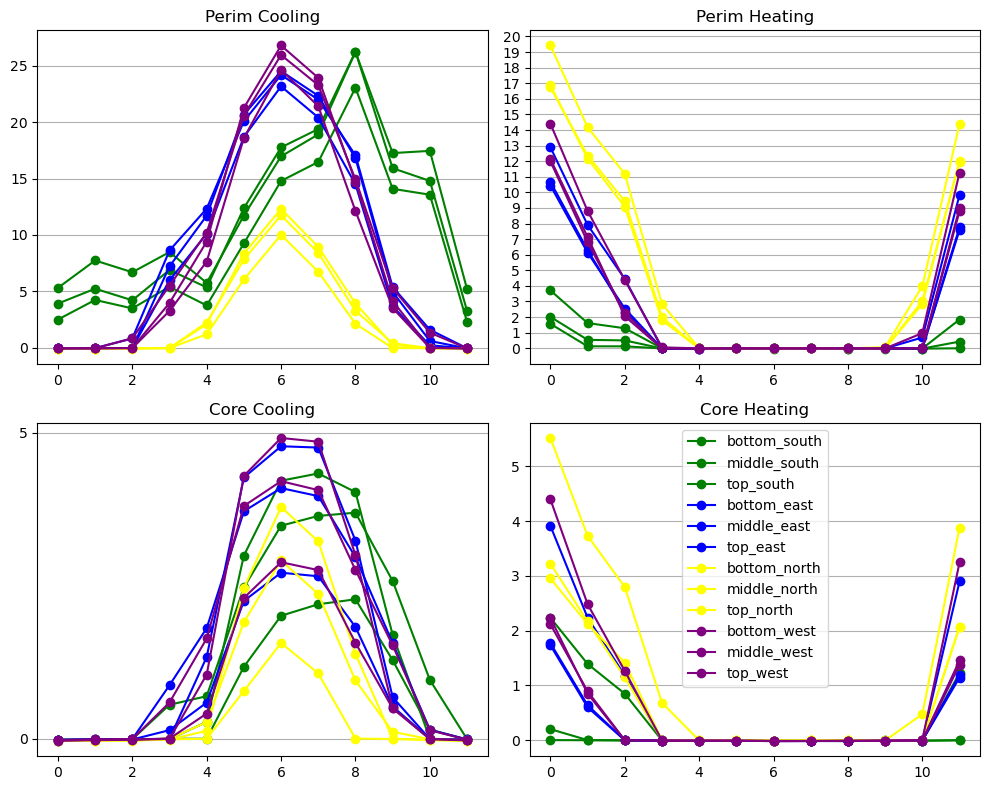

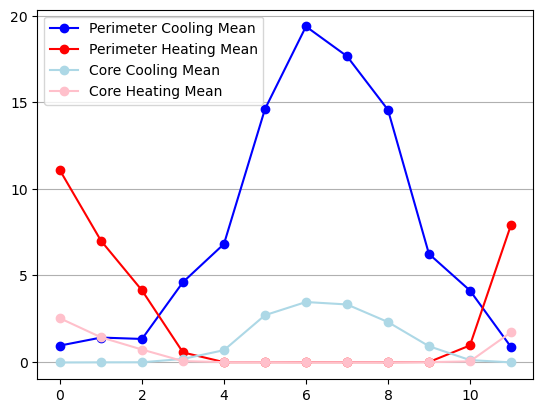

In [18]:
# shoebox_results = shoebox_results.set_index("box_name")
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

colors = {
    "bottom_south":"green",
    "middle_south": "green",
    "top_south": "green",
    "bottom_east":"blue",
    "middle_east": "blue",
    "top_east": "blue",
    "bottom_north":"yellow",
    "middle_north": "yellow",
    "top_north": "yellow",
    "bottom_west":"purple",
    "middle_west": "purple",
    "top_west": "purple",
}
fig,axs = plt.subplots(2,2,figsize=(10,8))
axs = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]

for i in range(12):
    axs[0].plot(shoebox_results["Perimeter"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[1].plot(shoebox_results["Perimeter"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[2].plot(shoebox_results["Core"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[3].plot(shoebox_results["Core"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])


# axs[0].set_ylim([0,80])
# axs[1].set_ylim([0,5])
axs[0].yaxis.set_major_locator(MultipleLocator(5))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[2].yaxis.set_major_locator(MultipleLocator(5))
axs[3].yaxis.set_major_locator(MultipleLocator(1))

axs[0].grid(axis="y",which="major")
axs[1].grid(axis="y",which="major")
axs[2].grid(axis="y",which="major")
axs[3].grid(axis="y",which="major")

axs[0].set_title("Perim Cooling")
axs[1].set_title("Perim Heating")
axs[2].set_title("Core Cooling")
axs[3].set_title("Core Heating")
plt.legend()
fig.tight_layout()

fig = plt.figure()
plt.plot(shoebox_results["Perimeter"]["Cooling"].mean(axis=0).values,"-o",color="blue",label="Perimeter Cooling Mean")
plt.plot(shoebox_results["Perimeter"]["Heating"].mean(axis=0).values,"-o",color="red",label="Perimeter Heating Mean")
plt.plot(shoebox_results["Core"]["Cooling"].mean(axis=0).values,"-o",color="lightblue",label="Core Cooling Mean",)
plt.plot(shoebox_results["Core"]["Heating"].mean(axis=0).values,"-o",color="pink",label="Core Heating Mean",)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.legend()
plt.grid(axis="y",which="major")

### Get CS results

In [19]:
with open(results_dir, 'r') as f:
    gh_results_data = json.load(f)
gh_results_data = {(outerKey, innerKey): values for outerKey, innerDict in gh_results_data.items() for innerKey, values in innerDict.items()}
gh_results_data = {outerKey + (innerKey,): values for outerKey, innerDict in gh_results_data.items() for innerKey, values in innerDict.items()}
gh_results = pd.DataFrame.from_dict(gh_results_data)


In [20]:
gh_results

CSshoeboxer                                 Autozoner                       \
       Cooling              Heating              Cooling              Heating   
          Core  Perimeter      Core  Perimeter      Core  Perimeter      Core   
0     0.000000   1.054948  1.703507  13.974754  0.000000   0.354981  1.673460   
1     0.000000   1.294965  0.849246   8.886686  0.000000   0.501879  1.010910   
2     0.000000   1.299750  0.495599   6.612002  0.000000   0.322583  0.597893   
3     0.028724   2.895866  0.040005   1.240676  0.026438   1.801030  0.073325   
4     0.440042   5.656253  0.000000   0.011197  0.372441   4.702527  0.000000   
5     2.084027  12.001422  0.000000   0.000000  1.826399  10.979220  0.000000   
6     3.140636  16.839430  0.000000   0.000000  2.743867  15.643620  0.000000   
7     2.719046  14.639725  0.000000   0.000000  2.389093  13.561639  0.000000   
8     1.731480  10.973739  0.000000   0.000000  1.556458   9.977817  0.000000   
9     0.119475   3.848925  0.000000   0.040378  0.184204   3.181652  0.000000   
10    0.001903   2.541938  0.020533   1.445004  0.061346   2.217786  0.120944   
11    0.000000   0.845998  1.079818  10.061963  0.000107   0.445524  1.141121   

               
               
    Perimeter  
0   11.857067  
1    7.249470  
2    5.018839  
3    0.854288  
4    0.012970  
5    0.000000  
6    0.000000  
7    0.000000  
8    0.000000  
9    0.037112  
10   1.435980  
11   8.469415

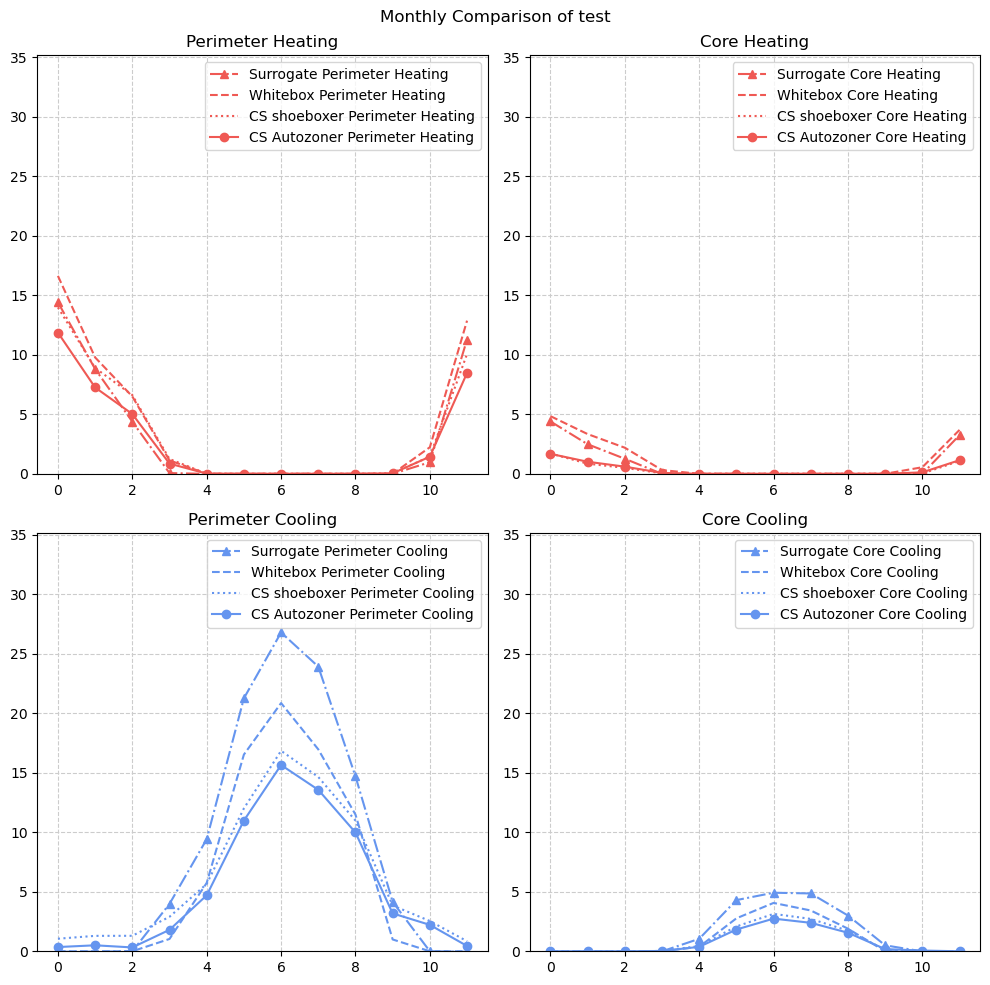

In [27]:
ix = -1
fig, axs = plt.subplots(2,2, figsize=(10,10))

for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        axs[row,col].set_title(f"{zone} {end_use}")
        axs[row,col].plot(shoebox_results[zone][end_use].values[ix], "^-.", label=f"Surrogate {zone} {end_use}", color=color)
        axs[row,col].plot(wb_shoebox_results[zone][end_use].values[ix], "--", label=f"Whitebox {zone} {end_use}", color=color)
        axs[row,col].plot(gh_results.CSshoeboxer[end_use][zone], ":", label=f"CS shoeboxer {zone} {end_use}", color=color)
        axs[row,col].plot(gh_results.Autozoner[end_use][zone], "o-", label=f"CS Autozoner {zone} {end_use}", color=color)
        # legend
        axs[row,col].legend()
fig.tight_layout()

absolute_max = max(axs[0, 0].get_ylim()[1], axs[1, 0].get_ylim()[1])
grid_size = 5
while absolute_max / grid_size > 20:
    grid_size += 5 
for i in range(2):
    axs[0, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[0, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[1, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[1, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[0, i].set_ylim([0,1.25*absolute_max])
    axs[1, i].set_ylim([0,1.25*absolute_max])
plt.legend()
plt.suptitle(f"Monthly Comparison of {name}")
fig.tight_layout()